In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tvDatafeed import TvDatafeed, Interval

In [2]:
import requests
import json
import datetime

In [3]:
n=1

In [4]:
tv = TvDatafeed()
def getdata(name):
    data=tv.get_hist(symbol=name,exchange='BINANCE',interval=Interval.in_daily,n_bars=5000)
    data=data.reset_index()
#     data["datetime"]=data["datetime"]+datetime.timedelta(days=1)
    data["datetime"]=data["datetime"].dt.strftime('%Y-%m-%d')
    data2=data[data["datetime"]>="2020-01-01"].copy()
    data2["datetime"] = pd.to_datetime(data2["datetime"])
    return data2

you are using nologin method, data you access may be limited


In [5]:
def getapi(api):
    response_API=requests.get(api)
    data=response_API.text
    parse_json=json.loads(data)
    df = pd.json_normalize(parse_json['values'])
    listtime=list(df['x'])
    listtime2=[]
    for i in listtime:
        listtime2.append(datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d'))
    df['datetime']=pd.Series(listtime2)
    df["datetime"] = pd.to_datetime(df["datetime"])
#     df["datetime"]=df["datetime"]+datetime.timedelta(days=1)
    df=df[df["datetime"]>="2020-01-01"].copy()
    df=df.drop(columns=['x'])
    df.rename(columns={'y':'value'},inplace=True)
    df=df.drop_duplicates(subset=['datetime'])
    return df

In [6]:
bitcoi=getdata('BTCUSDT')
eth=getdata('ETHUSDT')
bnb=getdata('BNBUSDT')
ada=getdata('ADAUSDT')
bitcoi=bitcoi[["datetime","volume","open","high","low","close"]]
bitcoi.tail(5)

,datetime,volume,open,high,low,close
1640,2022-02-11,26556.85681,42373.73,43079.49,41688.88,42217.87
1641,2022-02-12,17731.83401,42217.87,42760.00,41870.00,42053.66
1642,2022-02-13,34010.13060,42053.65,42842.40,41550.56,42535.94
1643,2022-02-14,38093.46331,42535.94,44751.40,42427.03,44544.86
1644,2022-02-15,3313.08790,44544.85,44549.97,43877.18,43995.96


In [7]:
number_transactions=getapi('https://api.blockchain.info/charts/n-transactions?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
number_address=getapi('https://api.blockchain.info/charts/n-unique-addresses?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=getapi('https://api.blockchain.info/charts/transactions-per-second?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=transaction_second.groupby(['datetime']).mean().reset_index()
total_bitcoin=getapi('https://api.blockchain.info/charts/total-bitcoins?timespan=4years&rollingAverage=24hours&format=json&sampled=true')
volume_trade=getapi('https://api.blockchain.info/charts/trade-volume?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
hash_rate=getapi('https://api.blockchain.info/charts/hash-rate?timespan=4years&rollingAverage=24hours&format=json&sampled=false')

In [8]:
bitcoin=bitcoi.merge(eth[["datetime","close"]],on='datetime',how='left',suffixes=('_bitcoin', '_eth'))
bitcoin=bitcoin.merge(bnb[["datetime","close"]],on='datetime',how='left')
bitcoin=bitcoin.merge(ada[["datetime","close"]],on='datetime',how='left',suffixes=('_bnb', '_ada'))

In [9]:
data_api=number_transactions.merge(number_address,on='datetime',how='left',suffixes=('_number_transaction', '_number_address'))
data_api=data_api.merge(transaction_second,on='datetime',how='left')
data_api=data_api.merge(total_bitcoin,on='datetime',how='left',suffixes=('_transaction_second', '_total_bitcoin'))
data_api=data_api.merge(volume_trade,on='datetime',how='left')
data_api=data_api.merge(hash_rate,on='datetime',how='left',suffixes=('_volume_trade', '_hash_rate'))


In [10]:
bitcoin=bitcoin.merge(data_api,on='datetime',how='left')
bitcoin.tail(5)

,datetime,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate
772,2022-02-11,26556.85681,42373.73,43079.49,41688.88,42217.87,2918.88,403.6,1.059,228189.0,604018.0,3.068403,1.895464e+07,3.225592e+08,2.481103e+08
773,2022-02-12,17731.83401,42217.87,42760.00,41870.00,42053.66,2871.13,397.9,1.042,208977.0,590527.0,2.986458,1.895553e+07,1.404551e+08,2.096333e+08
774,2022-02-13,34010.13060,42053.65,42842.40,41550.56,42535.94,2929.75,403.4,1.049,247592.0,630477.0,2.536632,1.895642e+07,9.067330e+07,2.029994e+08
775,2022-02-14,38093.46331,42535.94,44751.40,42427.03,44544.86,3183.52,432.4,1.107,273623.0,680501.0,2.481250,1.895731e+07,1.878267e+08,2.321888e+08
776,2022-02-15,3313.08790,44544.85,44549.97,43877.18,43995.96,3142.97,431.1,1.094,NaN,NaN,NaN,NaN,NaN,NaN


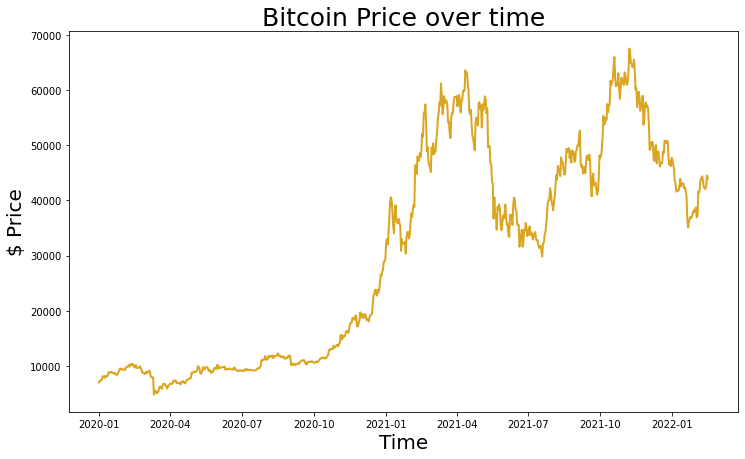

In [11]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["close_bitcoin"], color='goldenrod', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.show()

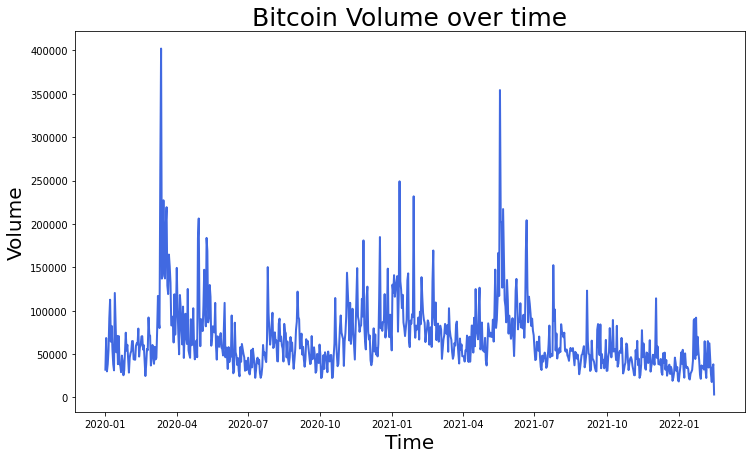

In [12]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["volume"], color='royalblue', lw=2)
plt.title("Bitcoin Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

In [13]:
bitcoin.isnull().sum()

datetime                     0
volume                       0
open                         0
high                         0
low                          0
close_bitcoin                0
close_eth                    0
close_bnb                    0
close_ada                    0
value_number_transaction     1
value_number_address         3
value_transaction_second     1
value_total_bitcoin         32
value_volume_trade           1
value_hash_rate              1
dtype: int64

In [14]:
# bitcoin=bitcoin.interpolate(method='linear')
temp=bitcoin["datetime"]
bitcoin=bitcoin.drop(columns=['datetime'])
bitcoin=bitcoin.interpolate()
bitcoin['datetime']=temp
bitcoin.isnull().sum()

volume                      0
open                        0
high                        0
low                         0
close_bitcoin               0
close_eth                   0
close_bnb                   0
close_ada                   0
value_number_transaction    0
value_number_address        0
value_transaction_second    0
value_total_bitcoin         0
value_volume_trade          0
value_hash_rate             0
datetime                    0
dtype: int64

In [15]:
required_features = ['volume','open', 'high', 'low','close_eth','close_bnb','close_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin','value_volume_trade', 'value_hash_rate']
output_label = ['close_bitcoin']

In [16]:
x_set=bitcoin[required_features]
y_set=bitcoin[output_label]
num_train=int(0.8*len(x_set))
x_train = x_set[0:num_train]
x_test = x_set[num_train:len(x_set)]
y_train = y_set[0:num_train]
y_test = y_set[num_train:len(y_set)]
# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [17]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = model.predict(x_test)
# Printout relevant metrics
print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))


Model Coefficients: [[-1.12629968e-03 -4.74735877e-01  9.19079299e-01  5.47587029e-01
  -1.24534558e-01  3.36586408e-01  1.94244745e+01  1.85906803e-03
  -1.02115009e-03  6.06007417e+01  6.66867522e-04  1.32975499e-07
  -3.53488000e-07]]
Mean Absolute Error: 595.0765117356361
Coefficient of Determination: 0.9921895206342791


In [19]:
future_set = bitcoin.tail(n).copy()
future_set

,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate,datetime
776,3313.0879,44544.85,44549.97,43877.18,43995.96,3142.97,431.1,1.094,273623.0,680501.0,2.48125,18957306.25,1.878267e+08,2.321888e+08,2022-02-15


In [20]:
prediction = model.predict(future_set[required_features])
prediction

array([[43891.34704545]])

In [21]:
today = datetime.date.today()
tomorrow = future_set["datetime"].iloc[0] + datetime.timedelta(days=1)
tmr = tomorrow.strftime("%B %d, %Y")
print("The prediction of bitcoin price on",tmr,"at 7 P.M. is",prediction[0])

The prediction of bitcoin price on February 16, 2022 at 7 P.M. is [43891.34704545]
